<a href="https://colab.research.google.com/github/rgsalcedo/MAGCalciumAccum/blob/main/Quick_Accum_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 0_Results_zone1_PRUEBA_Paper.xlsx to 0_Results_zone1_PRUEBA_Paper (3).xlsx


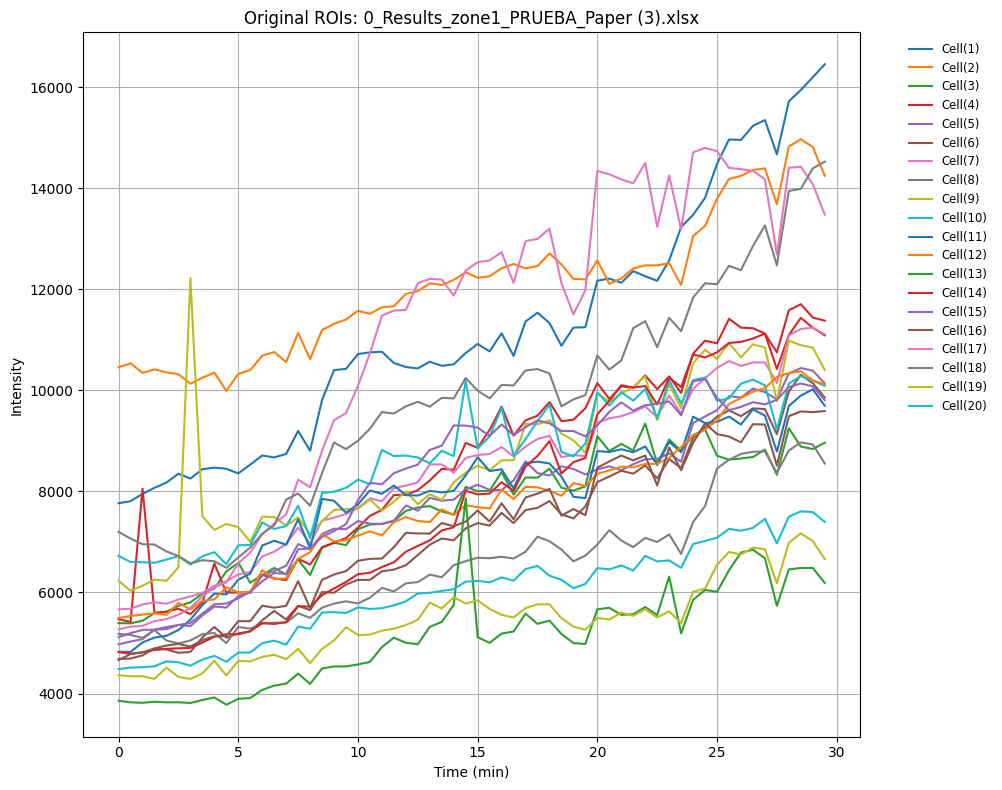

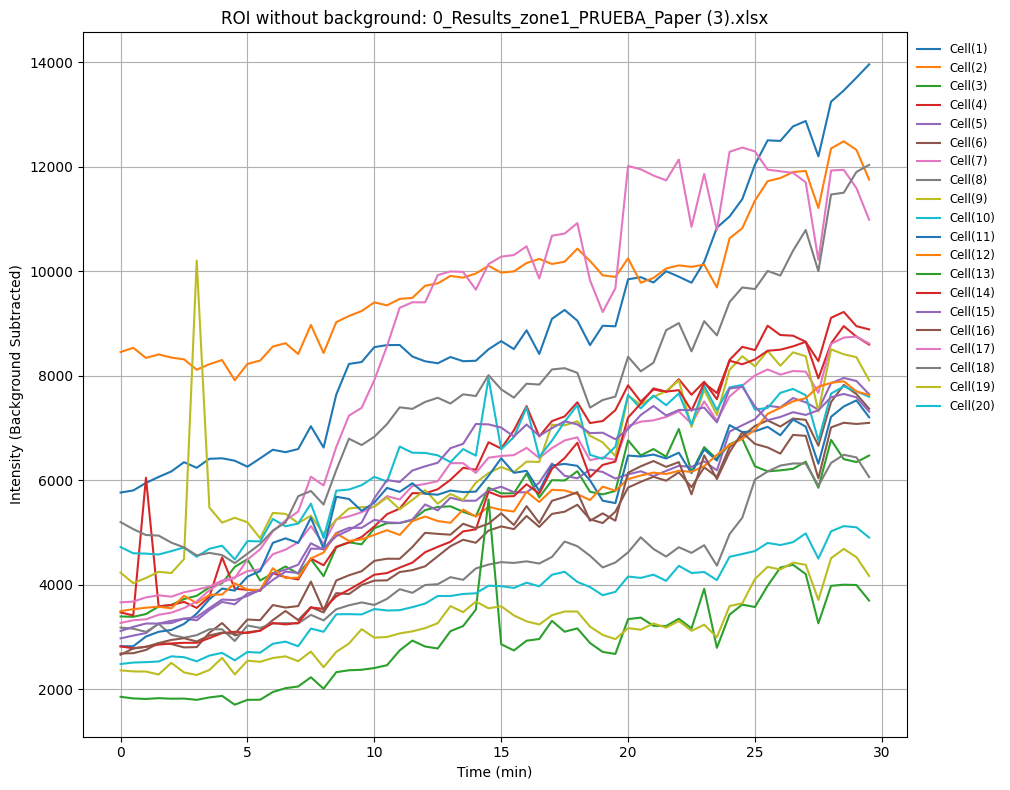

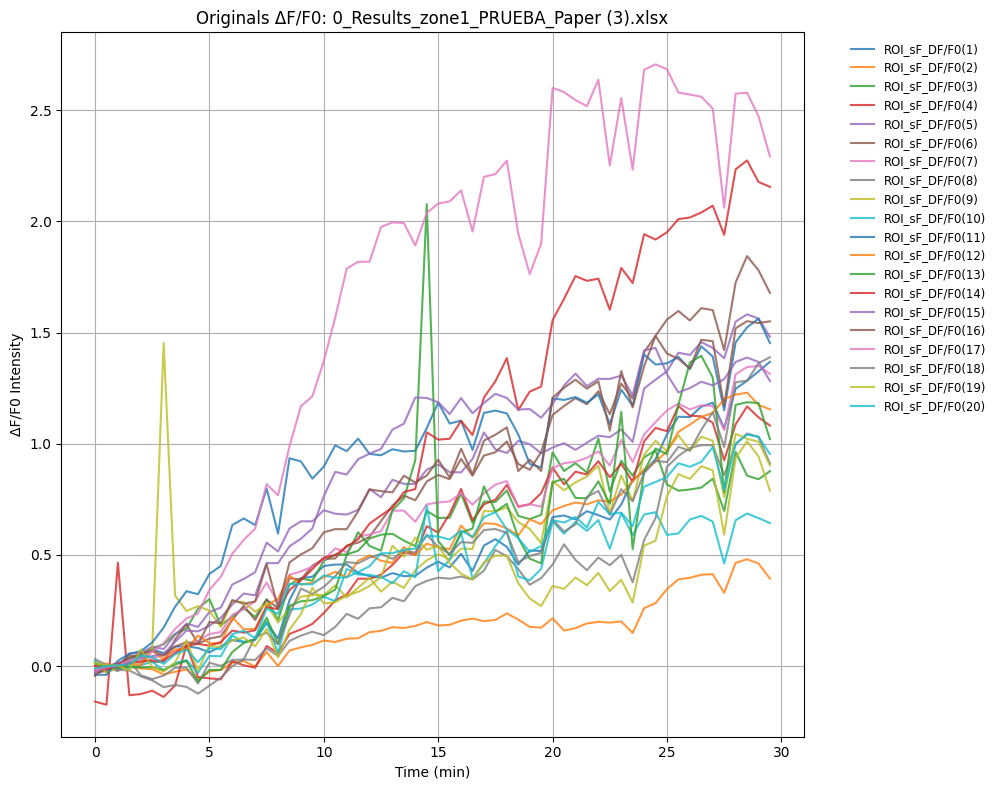

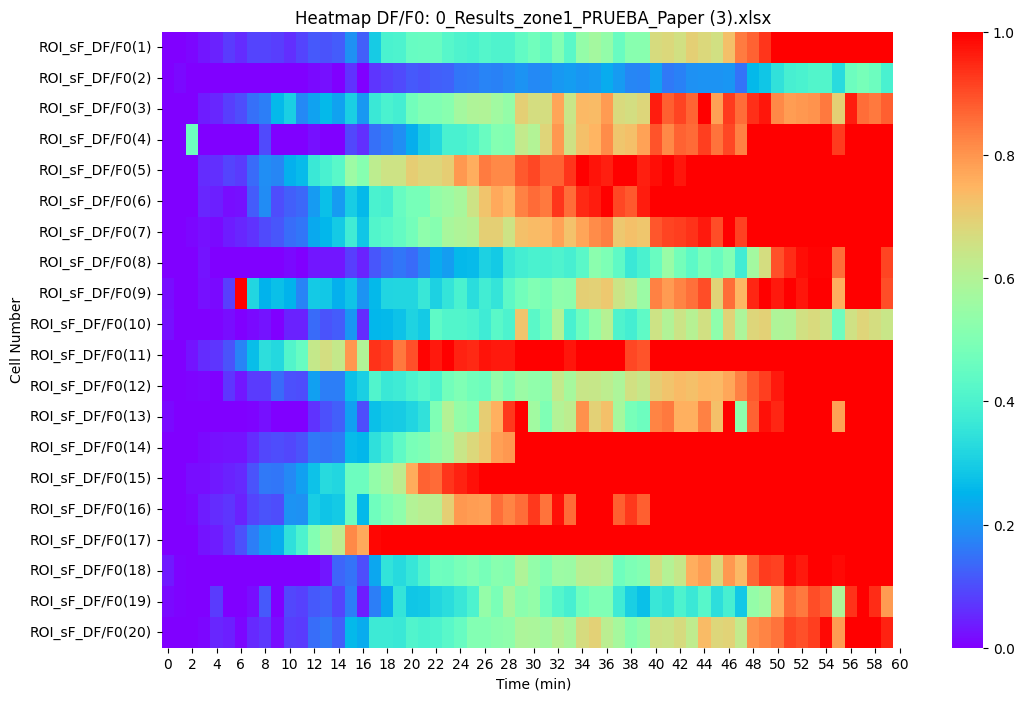

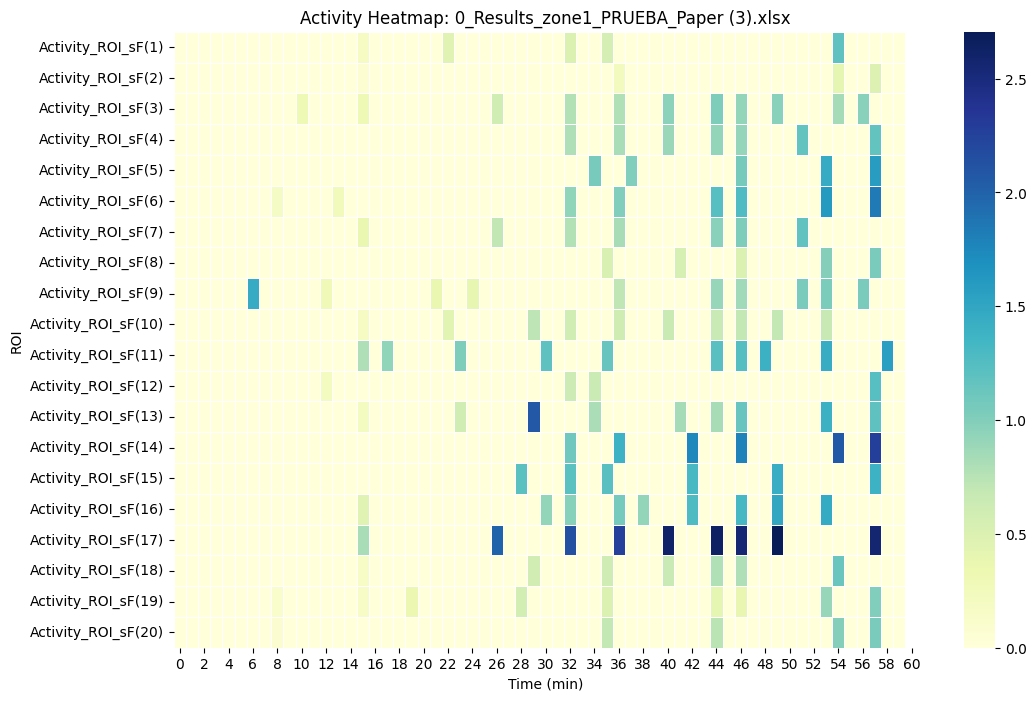

Calcium accumulation (AUC) for ROI 1: 23.73516370044948
Calcium accumulation (AUC) for ROI 2: 6.611575894985966
Calcium accumulation (AUC) for ROI 3: 27.851968333307223
Calcium accumulation (AUC) for ROI 4: 25.34099855374724
Calcium accumulation (AUC) for ROI 5: 40.64202021513461
Calcium accumulation (AUC) for ROI 6: 38.790502847267675
Calcium accumulation (AUC) for ROI 7: 31.623385640698725
Calcium accumulation (AUC) for ROI 8: 15.195334333807855
Calcium accumulation (AUC) for ROI 9: 25.3360730994667
Calcium accumulation (AUC) for ROI 10: 17.3903855203773
Calcium accumulation (AUC) for ROI 11: 46.51600417235764
Calcium accumulation (AUC) for ROI 12: 25.05660605243853
Calcium accumulation (AUC) for ROI 13: 22.970564733759172
Calcium accumulation (AUC) for ROI 14: 50.16841900671709
Calcium accumulation (AUC) for ROI 15: 45.5221310482835
Calcium accumulation (AUC) for ROI 16: 38.3687799264746
Calcium accumulation (AUC) for ROI 17: 75.61241978554621
Calcium accumulation (AUC) for ROI 18: 

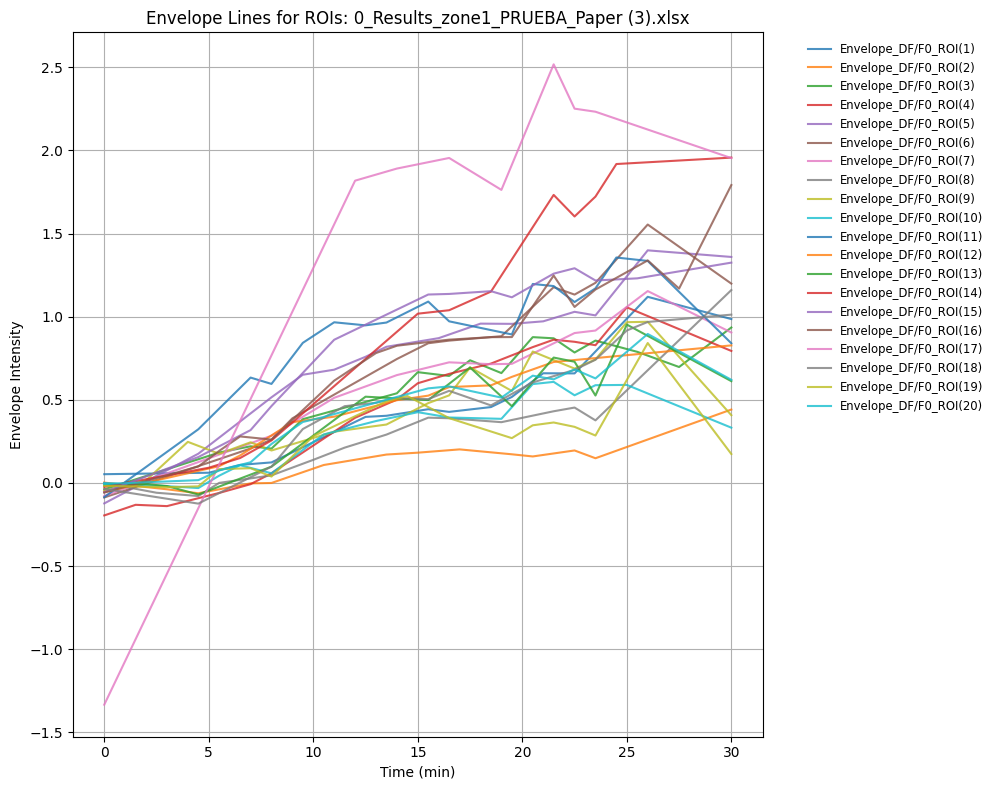

File saved as 'Analysis_with_Envelope.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Este programa hace todos los cálculos, incluida envelope y acumulación
# y genera un archivo Excel más organizado, en donde cada conjunto de cálculos
# los coloca en hojas diferentes, así como las Figuras que genera.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.signal import find_peaks
from io import BytesIO
import openpyxl
from openpyxl.drawing.image import Image
import io
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema

def load_data(file_path, sheet_name='Datos'):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

def process_data(df):
    df_sin_identificador = df.iloc[:, 1:]
    columna_vacia = df_sin_identificador.columns[df_sin_identificador.isna().all()].tolist()
    df_resultado = pd.DataFrame()

    if columna_vacia:
        idx_vacio = df_sin_identificador.columns.get_loc(columna_vacia[0])
        columnas_rois = df_sin_identificador.columns[:idx_vacio]
        columnas_fondo = df_sin_identificador.columns[idx_vacio + 1:]

        # Save the original ROIs in df_resultado at the beginning
        for i, col in enumerate(columnas_rois):
            df_resultado[f'Cell({i+1})'] = df_sin_identificador[col]

        # Insert a blank column before saving background values
        df_resultado[' '] = None

        # Step 2: Calculate the average background for each frame
        avg_fondo = df_sin_identificador[columnas_fondo].mean(axis=1)
        df_resultado['Avg_Fondo'] = avg_fondo

        # Insert a blank column
        df_resultado['  '] = None

        # Step 3: Subtract background from raw ROI
        roi_sin_fondo = pd.DataFrame({
            f'ROI_sF({i+1})': df_sin_identificador[col] - avg_fondo for i, col in enumerate(columnas_rois)
        })
        df_resultado = pd.concat([df_resultado, roi_sin_fondo], axis=1)

        # Insert a blank column
        df_resultado['   '] = None

        # Step 4: Calculate ΔF/F0 for each corrected ROI (F0 as the average of the first 4 frames)
        df_dff0_sin_fondo = pd.DataFrame()
        for i, col in enumerate(roi_sin_fondo.columns):
            roi_signal = roi_sin_fondo[col]
            F0 = roi_signal.iloc[:4].mean()
            df_dff0_sin_fondo[f'ROI_sF_DF/F0({i+1})'] = (roi_signal - F0) / F0
        df_resultado = pd.concat([df_resultado, df_dff0_sin_fondo], axis=1)

        # Insert a blank column
        df_resultado['      '] = None

        # Step 5: Activity based on ΔF/F0
        activity_sin_fondo = pd.DataFrame()
        activity_summary = {}  # Dictionary to store summary statistics for each ROI
        for i, col in enumerate(df_dff0_sin_fondo.columns):
            dff0_signal = df_dff0_sin_fondo[col]
            std_f0 = dff0_signal.iloc[:6].std()
            activity_threshold = 3 * std_f0
            selected_dff0_values = []  # Store DF/F0 values that meet the activity criteria for this ROI
            prominence_threshold = 0.05  # Prominence threshold of 5%

            # Find peaks that meet the prominence condition
            peaks, properties = find_peaks(dff0_signal, prominence=(prominence_threshold, None))

            # Initialize an array to store either the DF/F0 value (if it meets the threshold) or 0
            peak_activity = np.zeros(len(dff0_signal))

            # Store the DF/F0 values for peaks that meet the 3 standard deviation threshold
            for peak in peaks:
                if dff0_signal.iloc[peak] > activity_threshold:
                    peak_activity[peak] = dff0_signal.iloc[peak]
                    selected_dff0_values.append(dff0_signal.iloc[peak])

            # Save the activity for the ROI in the DataFrame (0 if no activity, value of DF/F0 if there is activity)
            activity_sin_fondo[f'Activity_ROI_sF({i+1})'] = peak_activity

            # Calculate summary statistics for the current ROI
            if selected_dff0_values:
                mean_selected_dff0 = np.mean(selected_dff0_values)
                std_selected_dff0 = np.std(selected_dff0_values)
                count_selected_dff0 = len(selected_dff0_values)
            else:
                mean_selected_dff0 = 0
                std_selected_dff0 = 0
                count_selected_dff0 = 0

            # Store the statistics in the summary dictionary
            activity_summary[f'Mean_Activity_DF/F0_ROI({i+1})'] = mean_selected_dff0
            activity_summary[f'STD_Activity_DF/F0_ROI({i+1})'] = std_selected_dff0
            activity_summary[f'Count_Activity_Frames_ROI({i+1})'] = count_selected_dff0

        # Add the activity data to df_resultado
        df_resultado = pd.concat([df_resultado, activity_sin_fondo], axis=1)

        # Insert a blank column before adding summary statistics
        df_resultado[' '] = None

        # Add summary statistics to df_resultado as a new row
        df_resultado = pd.concat([df_resultado, pd.DataFrame([activity_summary])], ignore_index=True)

        # Insert a blank column before adding new calculations
        df_resultado[' '] = None

    return df_resultado, columnas_rois

def plot_original_rois(df_resultado, columnas_rois, filename, figures):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, col in enumerate([col for col in df_resultado.columns if col.startswith("Cell(")]):
        ax.plot(df_resultado.index * 0.5, df_resultado[col], label=col)
    ax.set_title(f"Original ROIs: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Intensity")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    ax.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    figures["Original_ROIs"] = fig  # Store the figure

def plot_roi_without_background(df_resultado, columnas_rois, filename, figures):
    fig, ax = plt.subplots(figsize=(12, 8))
    for i in range(len(columnas_rois)):
        ax.plot(df_resultado.index * 0.5, df_resultado[f'ROI_sF({i+1})'], label=f'Cell({i+1})')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', frameon=False)
    ax.set_title(f"ROI without background: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Intensity (Background Subtracted)")
    ax.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    figures["ROI_without_Background"] = fig  # Store the figure

def plot_delta_f_over_f0(df_resultado, filename, figures):
    fig, ax = plt.subplots(figsize=(12, 8))
    for col in df_resultado.columns:
        if "ROI_sF_DF/F0" in col and "Detrended" not in col:
            ax.plot(df_resultado.index * 0.5, df_resultado[col], label=col, alpha=0.8)
    ax.set_title(f"Originals ΔF/F0: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("ΔF/F0 Intensity")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    ax.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    figures["DF_F0"] = fig  # Store the figure

def plot_heatmap_delta_f_over_f0(df_resultado, filename, figures):
    roi_sf_dff0_data = df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col and "Detrended" not in col]]
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(roi_sf_dff0_data.T, cmap="rainbow", cbar=True, annot=False, vmin=0, vmax=1, ax=ax)
    ax.set_title(f"Heatmap DF/F0: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Cell Number")
    plt.show()

    figures["Heatmap_DF_F0"] = fig  # Store the figure

def plot_heatmap_activity(df_resultado, filename, figures):
    activity_roi_sf_data = df_resultado[[col for col in df_resultado.columns if "Activity_ROI_sF" in col]]
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(activity_roi_sf_data.T, cmap="YlGnBu", cbar=True, annot=False, linewidths=.5, ax=ax)
    ax.set_title(f"Activity Heatmap: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("ROI")
    plt.show()

    figures["Activity_Heatmap"] = fig  # Store the figure

def calculate_envelope(df_dff0_sin_fondo):
    """
    Compute the lower envelope based on the DF/F0 data for each ROI.
    The envelope represents a smoothed curve that lies below all data points.
    """
    envelope_lines = pd.DataFrame()

    for i, col in enumerate(df_dff0_sin_fondo.columns):
        df_f_signal = df_dff0_sin_fondo[col]

        # Find local minima indices
        min_indices = argrelextrema(df_f_signal.values, np.less)[0]
        min_values = df_f_signal.iloc[min_indices]

        # Ensure there are enough points for interpolation
        if len(min_values) < 6:
            print(f"Not enough minima for ROI {i+1}. Skipping.")
            continue

        # Linear interpolation to create the envelope line
        interpolation_func = interp1d(min_indices, min_values, kind='linear', fill_value="extrapolate")
        envelope_line = interpolation_func(df_f_signal.index)

        # Smooth using forward and backward filling
        envelope_line_smooth = pd.Series(envelope_line).bfill().ffill()
        envelope_lines[f'Envelope_DF/F0_ROI({i+1})'] = envelope_line_smooth

    return envelope_lines

def calculate_calcium_accumulation(envelope_lines):
    """
    Compute calcium accumulation as the area under the DF/F0 envelope.
    The integration is performed using the trapezoidal rule.

    * To modify integration limits, change `start_frame` and `end_frame`. *
    """
    calcium_accumulation = {}

    # Define the integration limits
    start_frame = 4  # Modify this to change the starting frame
    end_frame = len(envelope_lines) - 4  # Modify this to change the end frame

    for i, col in enumerate(envelope_lines.columns):
        envelope_signal = envelope_lines[col].iloc[start_frame:end_frame]  # Apply limits
        area = np.trapz(envelope_signal, dx=1)  # Numerical integration (trapezoidal rule)
        calcium_accumulation[f'Calcium_AUC_ROI({i+1})'] = area

        # Print the result per ROI
        print(f"Calcium accumulation (AUC) for ROI {i+1}: {area}")

    return pd.DataFrame([calcium_accumulation])

def plot_all_envelopes(envelope_lines, filename, figures):
    """
    Plots all envelope lines for the ROIs, displays them, and stores the figure in a dictionary.
    """
    fig, ax = plt.subplots(figsize=(12, 8))

    for col in envelope_lines.columns:
        ax.plot(envelope_lines.index * 0.5, envelope_lines[col], label=col, alpha=0.8)

    ax.set_title(f"Envelope Lines for ROIs: {filename}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Envelope Intensity")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    ax.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    # Store figure in the dictionary
    figures["Envelope_Lines"] = fig


def save_results_to_excel(df_resultado, columnas_rois, filename, figures, envelope_lines, calcium_accumulation_df):
    output = BytesIO()

    with pd.ExcelWriter(output, engine='openpyxl') as workbook:
        # Save numerical results in separate sheets
        df_resultado[[col for col in df_resultado.columns if col.startswith("Cell(")]].to_excel(workbook, sheet_name='Original_ROIs', index=False)
        df_resultado[['Avg_Fondo']].to_excel(workbook, sheet_name='Average_Background', index=False)
        df_resultado[[col for col in df_resultado.columns if col.startswith("ROI_sF(")]].to_excel(workbook, sheet_name='ROI_without_Background', index=False)
        df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col]].to_excel(workbook, sheet_name='Delta_F_over_F0', index=False)
        df_resultado[[col for col in df_resultado.columns if col.startswith("Activity_ROI_sF(")]].to_excel(workbook, sheet_name='Activity', index=False)

        # Save envelope data
        envelope_lines.to_excel(workbook, sheet_name='Envelope_DF_F0', index=False)

        # Save calcium accumulation results
        calcium_accumulation_df.to_excel(workbook, sheet_name='Calcium_Accumulation', index=False)

        # Save figures in separate sheets
        book = workbook.book
        for fig_name, fig in figures.items():
            sheet = book.create_sheet(fig_name)  # Create a new sheet for each figure
            img_data = io.BytesIO()
            fig.savefig(img_data, format='png')
            img_data.seek(0)
            img = Image(img_data)
            sheet.add_image(img, "A1")  # Place the image at cell A1

    output.seek(0)

    output_file_path = 'Analysis_with_Envelope.xlsx'
    with open(output_file_path, 'wb') as f:
        f.write(output.getbuffer())

    print(f"File saved as '{output_file_path}'")
    files.download(output_file_path)

def select_file():
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    return file_path

def main():
    file_path = select_file()
    df = load_data(file_path, sheet_name='Datos')
    df_resultado, columnas_rois = process_data(df)

    figures = {}  # Dictionary to store figures

    # Generate and store all required plots
    plot_original_rois(df_resultado, columnas_rois, file_path, figures)
    plot_roi_without_background(df_resultado, columnas_rois, file_path, figures)
    plot_delta_f_over_f0(df_resultado, file_path, figures)
    plot_heatmap_delta_f_over_f0(df_resultado, file_path, figures)
    plot_heatmap_activity(df_resultado, file_path, figures)

    # Compute envelope using DF/F0
    envelope_lines = calculate_envelope(df_resultado[[col for col in df_resultado.columns if "ROI_sF_DF/F0" in col]])

    # Compute calcium accumulation
    calcium_accumulation_df = calculate_calcium_accumulation(envelope_lines)

    # Generate and store envelope plot
    plot_all_envelopes(envelope_lines, file_path, figures)

    # Save all results to Excel
    save_results_to_excel(df_resultado, columnas_rois, file_path, figures, envelope_lines, calcium_accumulation_df)
if __name__ == "__main__":
    main()